___
<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="50%" height="50%"/></p></a>
___
<center><em>Content Copyright by HongLab, Inc.</em></center>

#### 전체 미세조정(Full Fine-Tuning)

참고 자료
- [Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch) Chapter 7
- [Kanana: Compute-efficient Bilingual Language Models](https://arxiv.org/abs/2502.18934)

미세조정의 필요성
- LLM은 AI 에이전트의 품질을 결정짓는 핵심 요소
- 뭐든 그럴듯하게 대답해줄 수 있는 큰거 하나 (클라우드) vs 나의 목적에 특화된 작은거 여러 개 (로컬)
- "한국어" 잘하는 모델들이 공개되기 시작 (엑사원, 카나나 등) **감사합니다!**
- 사전훈련은 비용부담이 크지만 미세조정은 누구나 해볼만 하다
- RAG 성능에도 영향을 준다

앞에서는 LLM 모델을 사전훈련시키는 기본적인 원리에 대해 알아보았습니다. 사전훈련은 모델이 기본적인 언어 능력을 갖추도록 학습시키는 것으로 볼 수 있습니다. 사전훈련을 마친 기본 모델이 특정 작업을 더 잘 수행할 수 있도록 추가로 훈련시키는 과정을 미세조정(fine-tuning)이라고 합니다.

LLM을 훈련시킬 때는 GPU 사용료가 큰 부담이 된다는 것은 널리 알려진 사실입니다. 다행스럽게도 미세조정을 잘 활용하면 훨씬 적은 비용으로 나의 특정 용도에 최적화된 모델을 만들 수 있습니다. 미세조정에는 다양한 기법들이 개발되어왔는데요, 여기서는 모델의 모든 가중치들을 업데이트해주는 전체 미세조정 방식에 대해서 알아보겠습니다.

[안내]
- 본 내용은 쉬운 이해를 돕기 위해 최소한의 예제를 바탕으로 작성되었습니다. 실제 적용 범위에 대한 오해가 없으시길 바랍니다.
- 혹시 영상 업로드 후에 수정해야할 오류가 발견되면 강의노트에 적어두겠습니다.

#### 모델 준비

여기에서는 [카카오 나노 2.1b 베이스 모델](https://huggingface.co/kakaocorp/kanana-nano-2.1b-base)을 사용하겠습니다.

In [3]:
pip install transformers

   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.2 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.2 MB 764.3 kB/s eta 0:00:13
   -- ------------------------------------- 0.5/10.2 MB 764.3 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/10.2 MB 730.2 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/10.2 MB 730.2 kB/s eta 0:00:13
   ---- ----------------------------------- 1.0/10.2 MB 699.0 kB/s eta 0:00:14
   ---- ----------------------------------- 1.0/10.2 MB 699.0 kB/s eta 0:00:14
   ----- ---------------------------------- 1.3/10.2 MB 684.9 kB/s eta 0:00:13
   ----- ---------------------------------- 1.3/10.2 MB 684.9 kB/s eta 0:00:13
   ------ --------------------------------- 1.6/10.2 MB 699.0 kB/s eta 0:00:13
   ------

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "kakaocorp/kanana-nano-2.1b-base"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token # <|end_of_text|> 128001

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

C:\Users\jjj90\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jjj90\.cache\huggingface\hub\models--kakaocorp--kanana-nano-2.1b-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

#### 데이터셋 준비

In [1]:
qna_list = []
with open("jjcustomdata.txt", "r") as file:
    for line in file:
        qna = line.strip().split('|') # 안내: 입력 문서의 '|'는 질문과 답변을 구분하는 문자
        input_str = qna[0] + " " + qna[1]
        item = {'q':qna[0], 'input':input_str, 'q_ids':tokenizer.encode(qna[0]), 'input_ids':tokenizer.encode(input_str)}
        qna_list.append(item)

max_length = max(len(item['input_ids']) for item in qna_list) # + 1은 질문답변 사이의 빈칸

print(qna_list)
print(max_length)

UnicodeDecodeError: 'cp949' codec can't decode byte 0xeb in position 0: illegal multibyte sequence

In [ ]:
# 파인튜닝 전에 어떻게 응답하는지 확인

questions = [ qna['q'] for qna in qna_list]
questions.append("너에 대해서 설명해봐.")
questions.append("이처럼 인간처럼 생각하고 행동하는 AI 모델은 ")
questions.append("인공지능의 장점은")
questions.append("홍정모에 대해서 얘기해봐.")

input_ids = tokenizer(
    questions,
    padding=True,
    return_tensors="pt",
)["input_ids"].to("cuda")

# print(type(model))

model.eval()
with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=32,
        do_sample=False,
    )

output_list = output.tolist()

for i, output in enumerate(output_list):
    print(f"Q{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Q0: 다음 숫자들을 얘기해봐 12345 123456789 1234567890123456789 123456789012345678901234567890123456789012345678901234567
Q1: 홍정모가 좋아하는 과일은??
홍정모가 좋아하는 과일은?  홍정모가 좋아하는 과일은?  홍정모가 좋아하는 과일은
Q2: 홍정모가 좋아하는 게임은? 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11
Q3: 홍정모가 자주 가는 여행지는? (feat. 홍정모의 나혼자 코딩)
홍정모의 나혼자 코딩 저자 홍정모 출판 인사이트 발매
Q4: 홍정모의 취미는 무엇인가요? (feat. 홍정모의 파이썬 코딩 강의)
홍정모의 파이썬 코딩 강의를 듣
Q5: 홍정모가 좋아하는 계절은 무엇인가요? 홍정모가 좋아하는 계절은 봄입니다. 봄은 새로운 시작과 희망을 상징하는 계절로, 홍정모
Q6: 홍정모의 특기는 무엇인가요? (feat. 홍정모의 수학미적분학)
홍정모의 특기는 무엇인가요? (feat. 홍정모의 수
Q7: 홍정모가 자주 듣는 음악 장르는? (feat. 음악 추천)
홍정모가 자주 듣는 음악 장르는? (feat. 음악 추천)  홍정모가 자주 듣
Q8: 홍정모가 가장 좋아하는 색깔은? (feat. 색깔의 힘)
홍정모가 가장 좋아하는 색깔은? (feat. 색깔의 힘)  홍
Q9: 홍정모가 선호하는 영화 장르는? (feat. 영화 추천)
홍정모가 선호하는 영화 장르는? (feat. 영화 추천)  홍정모가 선호하는 영화
Q10: 홍정모가 좋아하는 운동은??
안녕하세요. 홍정모입니다. 오늘은 제가 좋아하는 운동에 대해 이야기해보려고 합니다. 저는 운동을 좋아하는 사람 중 한 명
Q11: 홍정모는 어떤 동물을 좋아하나요? 1. 홍정모는 어떤 동물을 좋아하나요? 2. 홍정모는 어떤 동물을 좋아하나요? 3. 홍
Q12: 홍정모가 주로 사용하는 소셜 미디어는? 1. 페이스북 2. 인스타그램 3. 트위터 4. 유튜브 5. 블로그 
Q13: 홍정모가 좋아하는 음식은??
홍정모가 좋아하는 음

Collate
- [파이토치 CrossEntropy의 ignore index = -100](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

EOT = 128001 # instruct 모델과 다름

class MyDataset(Dataset):
    def __init__(self, qna_list, max_length):
        self.input_ids = []
        self.target_ids = []

        for qa in qna_list:
            token_ids = qa['input_ids']
            input_chunk = token_ids
            target_chunk = token_ids[1:]
            input_chunk += [EOT]* (max_length - len(input_chunk))
            target_chunk +=  [EOT]* (max_length - len(target_chunk))
            len_ignore = len(qa['q_ids']) - 1 # target은 한 글자가 짧기 때문
            target_chunk[:len_ignore] = [-100] * len_ignore

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

dataset = MyDataset(qna_list, max_length=max_length)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
i = iter(train_loader)

In [ ]:
x, y = next(i)

y_temp = y[0].tolist()
y_temp = [x for x in y_temp if x != -100] # -100은 제외하고 디코딩

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y_temp))

<|begin_of_text|>홍정모가 자주 가는 여행지는? 홍정모는 특별히 자주 가는 여행지가 없습니다.<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|>
 홍정모는 특별히 자주 가는 여행지가 없습니다.<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|>


#### 훈련

[안내] 데이터셋이 너무 작아서 validation은 생략하였습니다.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#device = "cpu"
torch.manual_seed(123)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)

cuda


In [ ]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(10):
    model.train()  # Set model to training mode

    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch).logits # 뒤에 .logits를 붙여서 tensor만 가져옴

        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        print(f"{global_step} Tokens seen: {tokens_seen}")

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch).zfill(3) + ".pth")


0 Tokens seen: 66
1 Tokens seen: 132
2 Tokens seen: 198
3 Tokens seen: 264
4 Tokens seen: 330
5 Tokens seen: 396
6 Tokens seen: 462
7 Tokens seen: 528
Epoch: 0, Loss: 2.4990234375
8 Tokens seen: 594
9 Tokens seen: 660
10 Tokens seen: 726
11 Tokens seen: 792
12 Tokens seen: 858
13 Tokens seen: 924
14 Tokens seen: 990
15 Tokens seen: 1056
Epoch: 1, Loss: 0.3309326171875
16 Tokens seen: 1122
17 Tokens seen: 1188
18 Tokens seen: 1254
19 Tokens seen: 1320
20 Tokens seen: 1386
21 Tokens seen: 1452
22 Tokens seen: 1518
23 Tokens seen: 1584
Epoch: 2, Loss: 0.1495361328125
24 Tokens seen: 1650
25 Tokens seen: 1716
26 Tokens seen: 1782
27 Tokens seen: 1848
28 Tokens seen: 1914
29 Tokens seen: 1980
30 Tokens seen: 2046
31 Tokens seen: 2112
Epoch: 3, Loss: 0.0770416259765625
32 Tokens seen: 2178
33 Tokens seen: 2244
34 Tokens seen: 2310
35 Tokens seen: 2376
36 Tokens seen: 2442
37 Tokens seen: 2508
38 Tokens seen: 2574
39 Tokens seen: 2640
Epoch: 4, Loss: 0.043914794921875
40 Tokens seen: 2706
41 

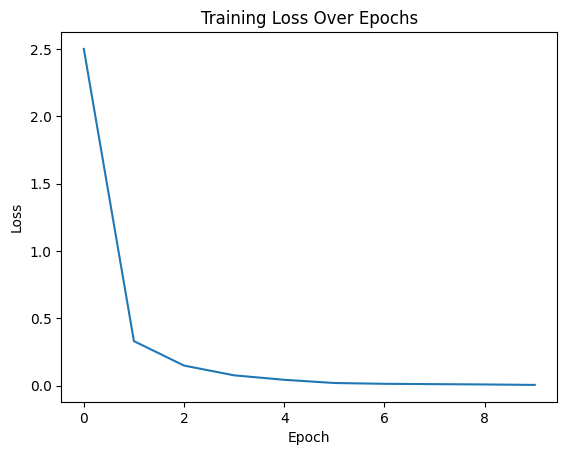

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

#### 결과확인

In [ ]:
# 파인튜닝 후에 어떻게 응답하는지 확인
model.load_state_dict(torch.load("model_009.pth", map_location=device, weights_only=True))
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 1792)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=1792, out_features=3072, bias=False)
          (k_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=1792, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (up_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (down_proj): Linear(in_features=8064, out_features=1792, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((1792,), eps=1e-05)
    (rotary_emb

In [ ]:
questions = [ qna['q'] for qna in qna_list]
questions.append("홍정모가 매일하는 게임은?")
questions.append("홍정모에 대해서 얘기해봐.")
questions.append("카나나 모델에 대해서 설명해봐.")
questions.append("이처럼 인간처럼 생각하고 행동하는 AI 모델은 ")
questions.append("인공지능의 장점은")

for i, q in enumerate(questions):

    input_ids = tokenizer(
        q,
        padding=True,
        return_tensors="pt",
    )["input_ids"].to("cuda")

    # print(type(model))

    model.eval()
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=32,
            attention_mask = (input_ids != 0).long(),
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            # temperature=1.2,
            # top_k=5
        )

    output_list = output.tolist()

    print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")



Q0: 다음 숫자들을 얘기해봐 12345 67890.
Q1: 홍정모가 좋아하는 과일은? 홍정모는 오렌지와 바나나를 좋아합니다.
Q2: 홍정모가 좋아하는 게임은? 홍정모는 헬다이버즈2를 좋아해서 자주합니다.
Q3: 홍정모가 자주 가는 여행지는? 홍정모는 특별히 자주 가는 여행지가 없습니다.
Q4: 홍정모의 취미는 무엇인가요? 홍정모는 독서와 영화 감상을 즐깁니다.
Q5: 홍정모가 좋아하는 계절은 무엇인가요? 홍정모는 여름을 가장 좋아합니다.
Q6: 홍정모의 특기는 무엇인가요? 아쉽게도 홍정모는 특별히 잘하는 것이 없습니다.
Q7: 홍정모가 자주 듣는 음악 장르는? 홍정모는 EDM을 자주 듣습니다.
Q8: 홍정모가 가장 좋아하는 색깔은? 홍정모는 여름을 가장 좋아합니다.
Q9: 홍정모가 선호하는 영화 장르는? 홍정모는 SF와 액션 영화를 선호합니다.
Q10: 홍정모가 좋아하는 운동은? 홍정모는 매일 조깅을 합니다.
Q11: 홍정모는 어떤 동물을 좋아하나요? 안타깝게도 홍정모는 애완동물을 키워본 적이 없습니다.
Q12: 홍정모가 주로 사용하는 소셜 미디어는? 홍정모는 유튜버입니다.
Q13: 홍정모가 좋아하는 음식은? 홍정모는 갈비찜을 아주 좋아합니다.
Q14: 홍정모가 가장 최근에 본 드라마는 무엇인가요? 홍정모는 최근에 데이데블 본어게인을 봤습니다.
Q15: 홍정모가 싫어하는 게임은 뭔가요? 홍정모는 사행성 게임을 싫어합니다.
Q16: 홍정모가 매일하는 게임은? 홍정모는 매일 헬다이버즈2를 합니다.
Q17: 홍정모에 대해서 얘기해봐. 홍정모는 한국의 유명한 가수입니다.
Q18: 카나나 모델에 대해서 설명해봐.
Q19: 이처럼 인간처럼 생각하고 행동하는 AI 모델은 2023년 현재까지는 아직 개발되지 않았습니다.
Q20: 인공지능의 장점은 무엇인가요? 인공지능은 다양한 장점을 가지고 있습니다. 첫째, 인공지능은 인간의 능력을 보완하고 확장시


In [ ]:
input_ids = tokenizer(
    input(),
    padding=True,
    return_tensors="pt",
)["input_ids"].to("cuda")

# print(type(model))

model.eval()
with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=32,
        attention_mask = (input_ids != 0).long(),
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        # temperature=1.2,
        # top_k=5
    )

output_list = output.tolist()

print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")

Q20: 홍정모는 누구지? 홍정모는 대한민국의 배우입니다.


#### 기타

허깅페이스 코드 참고한 부분들
- [라마 모델](https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py)
- [대답 생성하는 부분(generate)](https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py#L1906)
- [실제로 모델을 사용하는 부분(forward)](https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py#L2827)
- [훈련(train)](https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L2612)